In [22]:
import sys
import glob
import re
import fnmatch
import os
from os import listdir
from os.path import join, isfile, basename

import itertools

import numpy as np
from numpy import float32, int32, uint8, dtype, genfromtxt

import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import colorsys

In [4]:
# VFB labels and label names
labels = [16,64,8,32,2,4,65,66,33,67,34,17,69,70,35,71,9,18,72,36,73,74,37,75,19,76,38,77,39,78,79,20,5,40,80,10,81,82,83,84,85,86,11,22,23,24,12,3,6,49,50,25,51,13,52,26,53,27,54,55,56,28,7,14,57,58,29,59,30,60,15,61,31,62,63]
label_names_file = '/groups/saalfeld/home/bogovicj/vfb/DrosAdultBRAINdomains/refData/Original_Index.tsv'

label_names = pd.read_csv( label_names_file, delimiter='\t', header=0 )
# print label_names[ label_names['Stack id'] == 11 ]['JFRCtempate2010.mask130819' ].iloc[0]
# print label_names[ label_names['Stack id'] == 70 ]['JFRCtempate2010.mask130819' ].iloc[0]

def get_label_name( label_id ):
    return label_names[ label_names['Stack id'] == label_id ]['JFRCtempate2010.mask130819' ].iloc[0]

# label_names['JFRCtempate2010.mask130819']

label_shorthand_col ='JFRCtempate2010.mask130819'
label_id_col ='Stack id'


# Find left-right matching labels
rnames = label_names[ label_names.apply( lambda x : x[label_shorthand_col].endswith('_R'), axis=1 )]

lr_pair_list = []
for rn in rnames.loc[:,label_shorthand_col]:
    ln = rn.replace('_R','_L')
    id_R = label_names[ label_names[label_shorthand_col]==rn ].loc[:,label_id_col]
    id_L = label_names[ label_names[label_shorthand_col]==ln ].loc[:,label_id_col]
    lr_pair_list += [[id_R.values[0], id_L.values[0]]]
lr_pair_list = np.array( lr_pair_list )

In [5]:
path='/nrs/saalfeld/john/projects/flyChemStainAtlas/all_evals/F-antsFlip/cmtkCow/evalComp/stats0.txt'

def readlines( f ):
    f = open( f, 'r' )
    lines = f.readlines()
    f.close()
    return lines

def labelstat( lines, label, stat='MEDIAN'):
    statupper = stat.upper()
    for l in lines:
        if l.startswith(str(label)):
            if l.find(statupper) >= 0:
                return float( l.split()[2] )


In [49]:
base_dir = '/nrs/saalfeld/john/projects/flyChemStainAtlas/all_evals'

# templates = ['JFRCtemplate2010']
# reg_methods = [ 'cmtkCow', 'cmtkCOG', 'antsRegYang' ]

templates = ['JFRCtemplate2010', 'JFRC2013_lo', 'F-antsFlip_lo']
# reg_methods = [ 'cmtkCow', 'cmtkCOG', 'cmtkHideo' ]
# reg_methods = [ 'antsRegOwl', 'antsRegDog', 'antsRegYang' ]
reg_methods = [ 'cmtkCow', 'cmtkCOG', 'cmtkHideo', 'antsRegOwl', 'antsRegDog', 'antsRegYang' ]


In [64]:
# parse all data into a data frame

expnamelist=[]
statlist=[]
datalist=[]
labellist=[]
linelist=[]

for template,reg in itertools.product( templates, reg_methods ):

    exp_dir = join( base_dir, template, reg )
#     print exp_dir
    name_f = join(exp_dir,'name')
    if os.path.isfile( name_f ):
        expname = readlines( join(exp_dir,'name'))[0]
    else:
        expname = '{},{}'.format(template,reg)

#     print expname 
    for line in [0,1,2,3]:
        eval_dir=join(exp_dir,'evalComp')
#         print eval_dir
        # Read label stats
        statFile = '{}/stats{}.txt'.format(eval_dir,line)
        stat_lines = readlines( statFile )
        for sl in stat_lines:
            dat = sl.split()
            expnamelist += [ expname.replace('\n','') ]
            linelist += [ line ]
            labellist += [ int(dat[0]) ]
            statlist += [ dat[1] ]
            datalist += [ float(dat[2]) ]
            
        # Read total brain mask stats
        allStatFile = '{}/all_stats{}.txt'.format(eval_dir,line)
        all_stat_lines = readlines( allStatFile )
        for sl in all_stat_lines:
            if( sl.startswith('all ')):
                dat = sl.split()
                expnamelist += [ expname.replace('\n','') ]
                linelist += [ line ]
                labellist += [ -1 ] # -1 indicates total mask label
                statlist += [ dat[1] ]
                datalist += [ float(dat[2]) ]


dist_df = pd.DataFrame( {'EXP':expnamelist, 
                         'STAT':statlist,
                         'LINE':linelist,
                         'LABEL':labellist,
                         'VALUE':datalist })


In [51]:
# For each line, Sort labels by average size

avg_counts = []

gb_line_label = dist_df[ (dist_df.STAT == 'COUNT') ].groupby(['LINE','LABEL'], as_index=False )
line_label_avgs = gb_line_label.mean().sort_values('VALUE', ascending=False)


In [62]:

# Figure out colors
colorsys.hsv_to_rgb( 0.5, 0.5, 0.4 )
gc = (0.2,1.0,0.2)
kc = (0.0,0.0,0.0)
yc = (0.7,0.7,0.0)

numTemplates = 3
numRegalgs = 6

plot_colors = []

for ti,ai in itertools.product( range(numTemplates), range(numRegalgs)):
#     print ti,ai
    plot_colors += [ colorsys.hsv_to_rgb( float(ti)/numTemplates, 0.25 + 0.75*float(ai)/numRegalgs, 1.0  )]


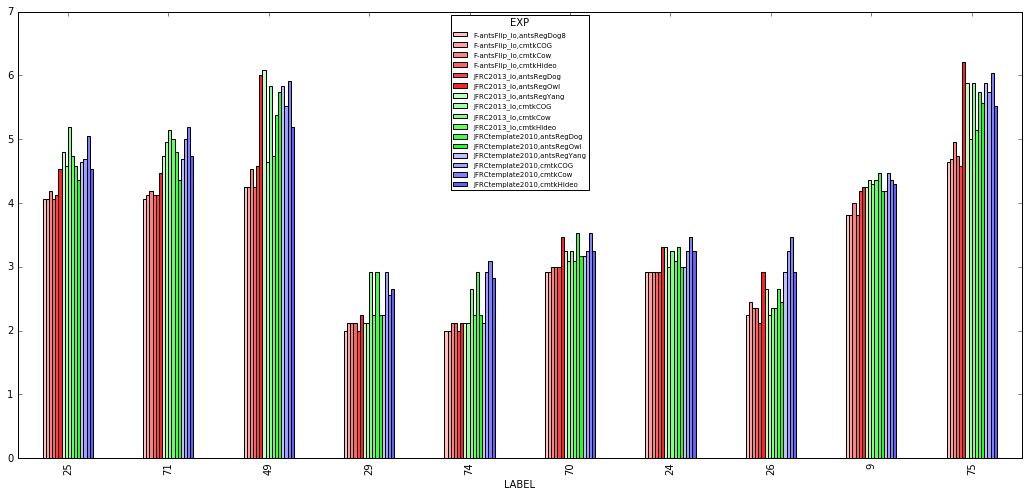

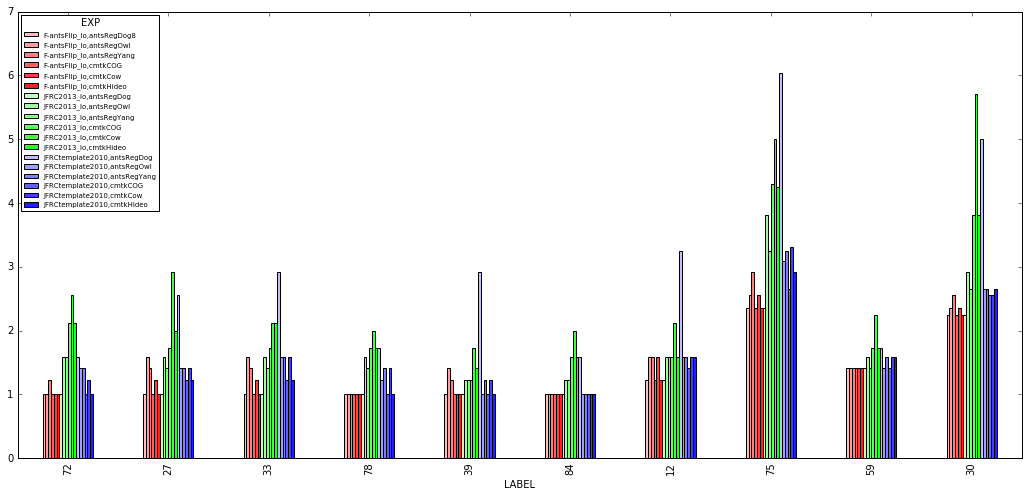

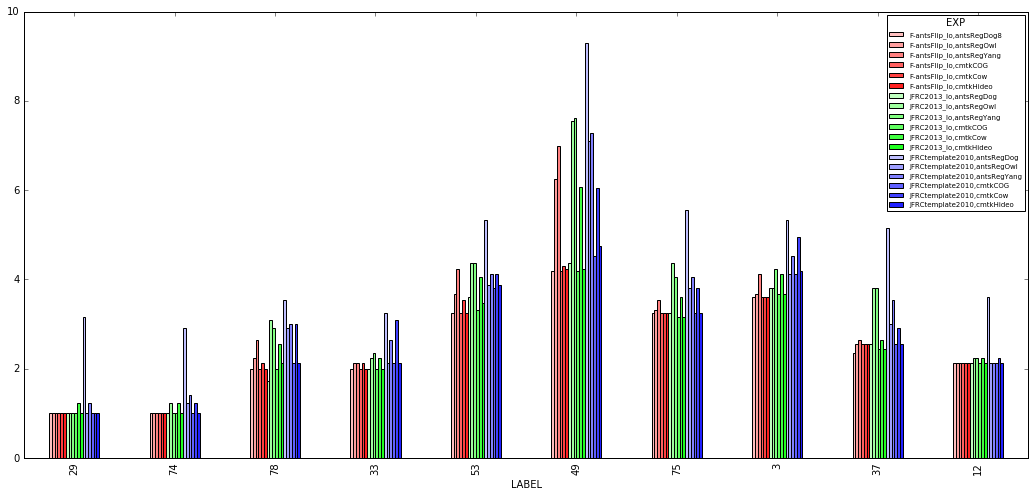

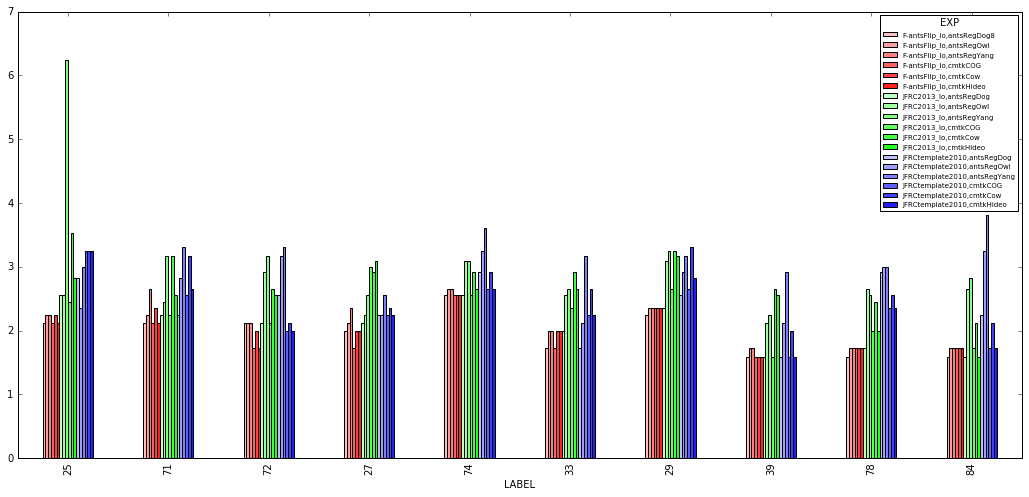

In [61]:
# For each line, plot the median distance over templates/regMethod

# Only plot for the top N labels
N = 10
line = 0
# fig, axs = plt.subplots(1,4)

plt.rc('legend',fontsize=7) # using a size in points

for line in [0,1,2,3]:
    #     print line
    # Get the top N labels for this line
    l = line_label_avgs[ (line_label_avgs.LINE == line ) & (line_label_avgs.LABEL > 0) ].head( N ).LABEL
    med_df = dist_df[(dist_df.STAT == 'MEDIAN') & (dist_df.LINE == line) & (dist_df.LABEL > 0) ]
    med_df_piv = med_df[['EXP','LABEL','VALUE']].pivot( index='LABEL', columns='EXP', values='VALUE' )
#     med_df_piv.loc[ l ].plot.bar( color=['g','g','g','k','k','k','y','y','y'])
#     med_df_piv.loc[ l ].plot.bar( color=[gc,gc,gc,kc,kc,kc,yc,yc,yc])
    med_df_piv.loc[ l ].plot.bar( color=plot_colors )
    
    fig = plt.gcf()
    a = fig.set_size_inches( 18, 8 )

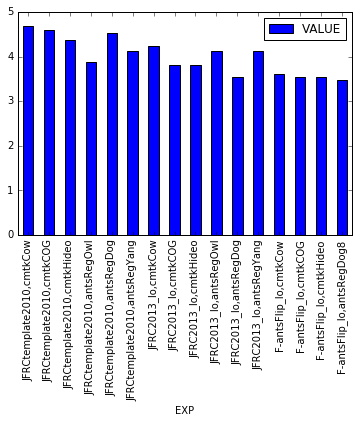

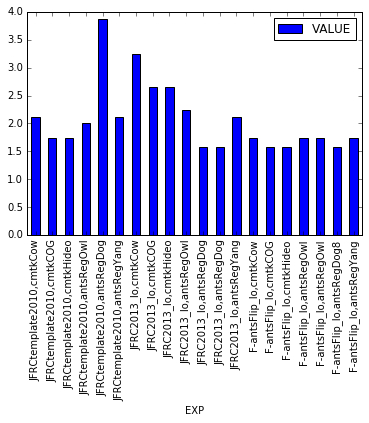

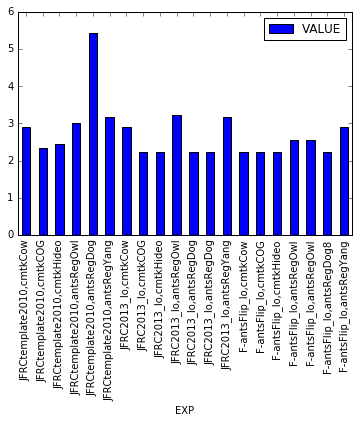

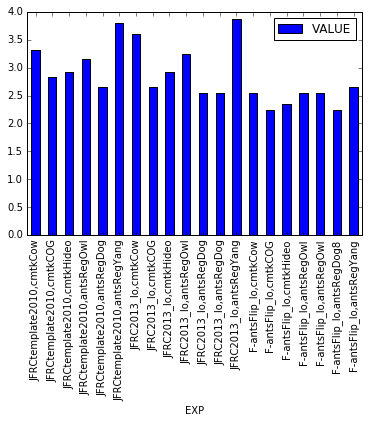

In [58]:
# For each line, plot the median distance over all labels for templates/regMethod 

for line in [0,1,2,3]:
    med_df = dist_df[(dist_df.STAT == 'MEDIAN') & (dist_df.LINE == line) & (dist_df.LABEL == -1)]
    med_df[['EXP','VALUE']].set_index('EXP').plot.bar()